In [1]:
import pickle
import sys

import numpy as np
import tensorflow as tf
from IPython.core.display import HTML
from sklearn.model_selection import train_test_split
from tensorflow.python.framework.errors_impl import NotFoundError

from src.cfd import CFD
from src.dataset import X_TIME, TIME_STEP
from src.gauss_hist import get_gauss_stats
from src.models import optimal_model_builder_all_ch, optimal_model_builder_ch_2_11
from src.network_utils import train_model as _base_train_model, plot_difference_hist, plot_history, compare_results, \
    gaussian_kernel

PWD = '../../../..'
sys.path.append(PWD)

tf.get_logger().setLevel('ERROR')

In [2]:
N_JOBS = 16

TRAIN_DATASET_PATHS = [
    PWD + '/data/dataset/dataset_r354332.pkl',
    PWD + '/data/dataset/dataset.pkl',
    PWD + '/data/dataset/dataset_r355445.pkl',
    PWD + '/data/dataset/dataset_r355558.pkl',
    PWD + '/data/dataset/dataset_r355680.pkl',
    PWD + '/data/dataset/dataset_r355769.pkl',
]

TEST_DATASET_PATH = PWD + '/data/dataset/dataset_r370138.pkl'

PRINT_PCOV = False

N_BASELINE = 6

LR = 0.05
ES_MIN_DELTA = 0.01

N_EPOCHS = 3000
BATCH_SIZE = 8192
LOSS_WEIGHT = 1000

CFD_THRESHOLD_SPACE = np.arange(0.12, 0.25, 0.005)
OPTIMAL_CFD_THRESHOLDS_TRAIN_DATA_PATH = PWD + '/data/tmp/many_channels_tests/optimal_cfd_thresholds_r354332_2022.pkl'

TRAIN_TEST_SPLIT_RANDOM_STATE = 42
TEST_SIZE = 0.2

In [3]:
train_datasets = []
for path in TRAIN_DATASET_PATHS:
    with open(path, 'rb') as file:
        train_datasets.append(pickle.load(file))

with open(TEST_DATASET_PATH, 'rb') as file:
    test_dataset = pickle.load(file)

# Utils

In [4]:
def model_predict(model: tf.keras.Model, X: np.ndarray):
    Y_heatmap_pred = model.predict(X, batch_size=BATCH_SIZE)

    y_pred = np.empty(Y_heatmap_pred.shape[0])
    for i, y in enumerate(Y_heatmap_pred):
        _, y_pred[i], _, _ = get_gauss_stats(X_TIME, y, a_0=1, std_0=1. * TIME_STEP)

    return y_pred

In [5]:
def train_model(model, name, X_train, y_train, X_val, y_val, lr=LR, train=False, n_epochs=N_EPOCHS, verbose=1,
                batch_size=BATCH_SIZE, lr_patience=6, es_patience=50, es_min_delta=ES_MIN_DELTA,
                loss_weights=LOSS_WEIGHT):
    return _base_train_model(model, name, 'many_channels_tests/trained_on_runs_sep_r370138', X_train, y_train, X_val, y_val, lr,
                             train, n_epochs, verbose, batch_size, lr_patience, es_patience, es_min_delta, loss_weights,
                             root=PWD + '/data')

# Load optimal CFD thresholds

In [6]:
# from src.cfd import find_optimal_cfd_threshold
#
# optimal_cfd_thresholds = {}
# for plane, channel in sorted(test_dataset.keys()):
#     print(f'Processing p={plane}, ch={channel}...')
#     all_X, all_y = test_dataset[(plane, channel)][0], test_dataset[(plane, channel)][1]
#     # X_train, _, y_train, _ = train_test_split(all_X, all_y, test_size=TEST_SIZE, random_state=TRAIN_TEST_SPLIT_RANDOM_STATE)
#
#     optimal_cfd_threshold = find_optimal_cfd_threshold(CFD_THRESHOLD_SPACE, N_BASELINE, all_X, all_y, X_TIME, n_jobs=N_JOBS, plot=False)
#     optimal_cfd_thresholds[(plane, channel)] = optimal_cfd_threshold
#
# with open(OPTIMAL_CFD_THRESHOLDS_TRAIN_DATA_PATH, 'wb') as file:
#     pickle.dump(optimal_cfd_thresholds, file)

In [7]:
with open(OPTIMAL_CFD_THRESHOLDS_TRAIN_DATA_PATH, 'rb') as file:
    optimal_cfd_thresholds = pickle.load(file)

print('Optimal thresholds:')
for (plane, channel), threshold in optimal_cfd_thresholds.items():
    print(f'({plane:>1}, {channel:>2}): {threshold:0.3f}')

Optimal thresholds:
(1,  2): 0.170
(1, 11): 0.165
(2,  2): 0.205
(2, 11): 0.145
(3,  2): 0.135
(3, 11): 0.140


# Train the network

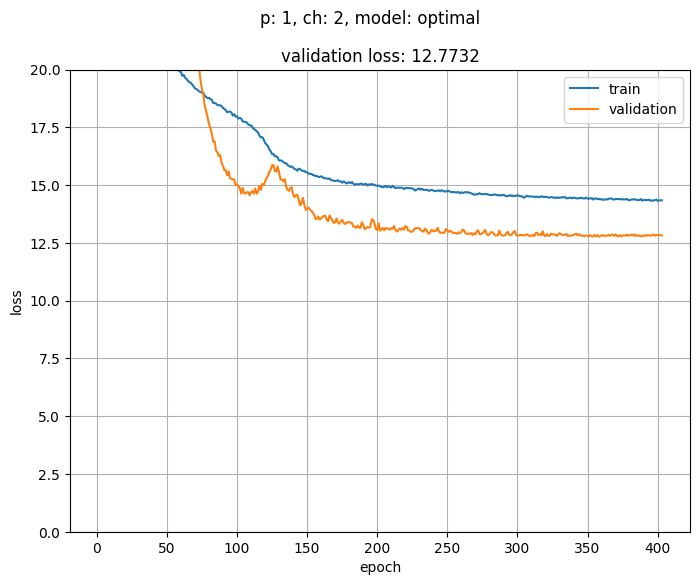

Could not find the model for (1, 11). Setting train=True
Epoch 1/3000
6/6 [==============================] - 6s 340ms/step - loss: 182.5109 - val_loss: 753.0510 - lr: 0.0500
Epoch 2/3000
6/6 [==============================] - 1s 115ms/step - loss: 49.6311 - val_loss: 87027.6016 - lr: 0.0500
Epoch 3/3000
6/6 [==============================] - 1s 114ms/step - loss: 39.3289 - val_loss: 140117.7812 - lr: 0.0500
Epoch 4/3000
6/6 [==============================] - 1s 114ms/step - loss: 33.5422 - val_loss: 45135.2930 - lr: 0.0500
Epoch 5/3000
6/6 [==============================] - 1s 114ms/step - loss: 29.6368 - val_loss: 25870.7461 - lr: 0.0500
Epoch 6/3000
6/6 [==============================] - 1s 114ms/step - loss: 26.8998 - val_loss: 6562.3335 - lr: 0.0500
Epoch 7/3000
6/6 [==============================] - 1s 114ms/step - loss: 24.6673 - val_loss: 2135.8982 - lr: 0.0500
Epoch 8/3000
6/6 [==============================] - 1s 127ms/step - loss: 22.9907 - val_loss: 611.3429 - lr: 0.0500
Epo

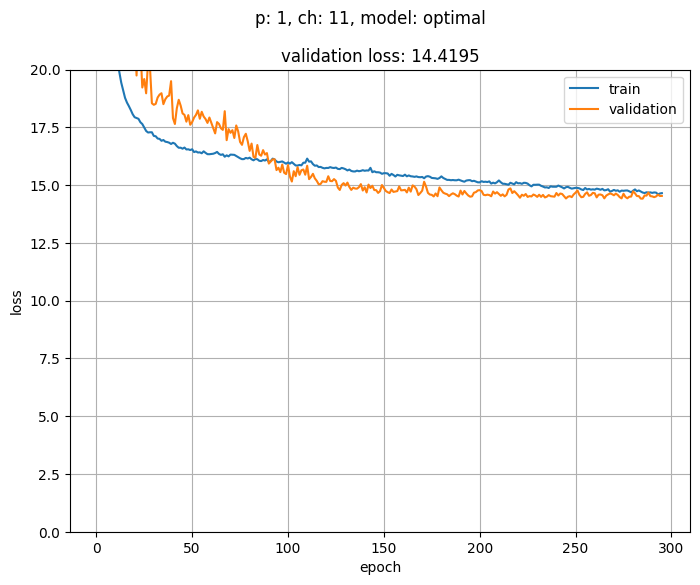

Could not find the model for (2, 2). Setting train=True
Epoch 1/3000
8/8 [==============================] - 3s 200ms/step - loss: 6866.6621 - val_loss: 34196809728.0000 - lr: 0.0500
Epoch 2/3000
8/8 [==============================] - 1s 117ms/step - loss: 548.1902 - val_loss: 809976256.0000 - lr: 0.0500
Epoch 3/3000
8/8 [==============================] - 1s 116ms/step - loss: 339.6317 - val_loss: 11392389.0000 - lr: 0.0500
Epoch 4/3000
8/8 [==============================] - 1s 116ms/step - loss: 266.8008 - val_loss: 2458.3955 - lr: 0.0500
Epoch 5/3000
8/8 [==============================] - 1s 117ms/step - loss: 190.3859 - val_loss: 1883.3549 - lr: 0.0500
Epoch 6/3000
8/8 [==============================] - 1s 105ms/step - loss: 142.5244 - val_loss: 12980.5430 - lr: 0.0500
Epoch 7/3000
8/8 [==============================] - 1s 106ms/step - loss: 122.1452 - val_loss: 2030.8701 - lr: 0.0500
Epoch 8/3000
8/8 [==============================] - 1s 117ms/step - loss: 104.6332 - val_loss: 417.6

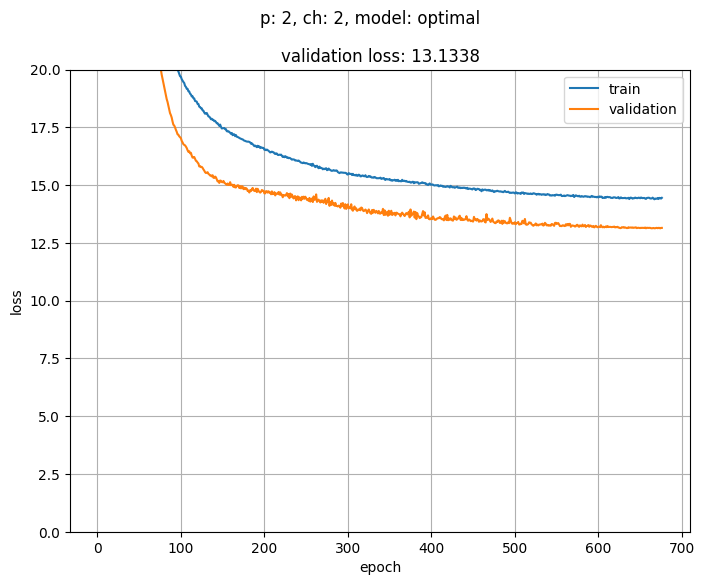

Could not find the model for (2, 11). Setting train=True
Epoch 1/3000
6/6 [==============================] - 3s 315ms/step - loss: 5484.4155 - val_loss: 1043128320.0000 - lr: 0.0500
Epoch 2/3000
6/6 [==============================] - 1s 127ms/step - loss: 488.6252 - val_loss: 229163520.0000 - lr: 0.0500
Epoch 3/3000
6/6 [==============================] - 1s 127ms/step - loss: 361.6870 - val_loss: 41858764.0000 - lr: 0.0500
Epoch 4/3000
6/6 [==============================] - 1s 127ms/step - loss: 290.4478 - val_loss: 995670.1250 - lr: 0.0500
Epoch 5/3000
6/6 [==============================] - 1s 125ms/step - loss: 239.5841 - val_loss: 56805.8125 - lr: 0.0500
Epoch 6/3000
6/6 [==============================] - 1s 127ms/step - loss: 190.3108 - val_loss: 15891.3623 - lr: 0.0500
Epoch 7/3000
6/6 [==============================] - 1s 112ms/step - loss: 162.0352 - val_loss: 37842.0703 - lr: 0.0500
Epoch 8/3000
6/6 [==============================] - 1s 127ms/step - loss: 138.8841 - val_loss: 4

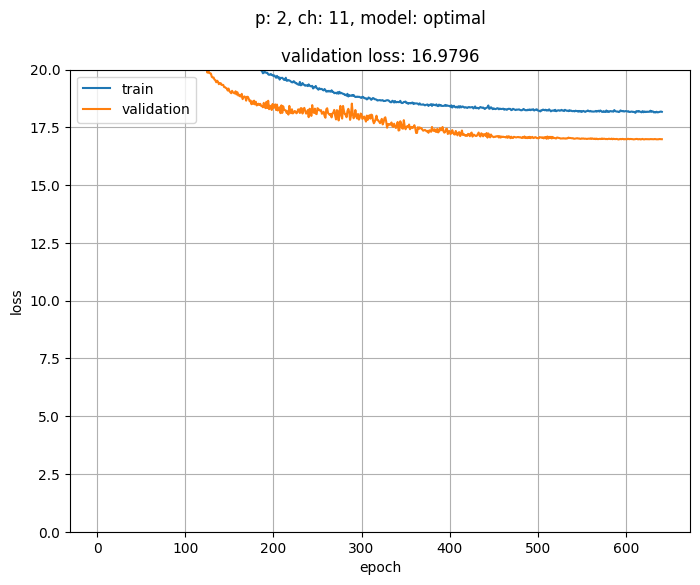

Could not find the model for (3, 2). Setting train=True
Epoch 1/3000
8/8 [==============================] - 3s 196ms/step - loss: 5676.5049 - val_loss: 212877574144.0000 - lr: 0.0500
Epoch 2/3000
8/8 [==============================] - 1s 115ms/step - loss: 392.9115 - val_loss: 106101880.0000 - lr: 0.0500
Epoch 3/3000
8/8 [==============================] - 1s 113ms/step - loss: 334.8992 - val_loss: 207223.7031 - lr: 0.0500
Epoch 4/3000
8/8 [==============================] - 1s 114ms/step - loss: 269.5047 - val_loss: 10617.5791 - lr: 0.0500
Epoch 5/3000
8/8 [==============================] - 1s 114ms/step - loss: 205.2710 - val_loss: 10197.5986 - lr: 0.0500
Epoch 6/3000
8/8 [==============================] - 1s 115ms/step - loss: 170.3081 - val_loss: 540.6122 - lr: 0.0500
Epoch 7/3000
8/8 [==============================] - 1s 115ms/step - loss: 144.7843 - val_loss: 155.4304 - lr: 0.0500
Epoch 8/3000
8/8 [==============================] - 1s 115ms/step - loss: 117.1950 - val_loss: 112.149

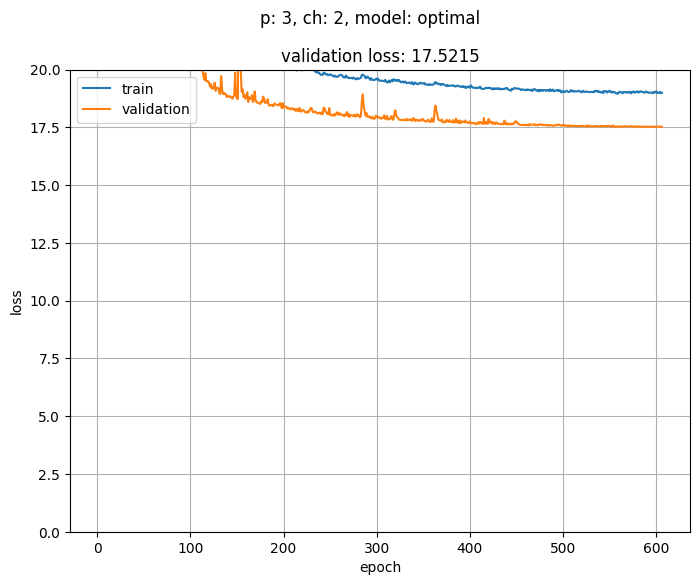

Could not find the model for (3, 11). Setting train=True
Epoch 1/3000
6/6 [==============================] - 3s 312ms/step - loss: 9471.0615 - val_loss: 80130859008.0000 - lr: 0.0500
Epoch 2/3000
6/6 [==============================] - 1s 127ms/step - loss: 432.2263 - val_loss: 16194520064.0000 - lr: 0.0500
Epoch 3/3000
6/6 [==============================] - 1s 127ms/step - loss: 390.5764 - val_loss: 5061872.5000 - lr: 0.0500
Epoch 4/3000
6/6 [==============================] - 1s 111ms/step - loss: 339.6901 - val_loss: 107106936.0000 - lr: 0.0500
Epoch 5/3000
6/6 [==============================] - 1s 127ms/step - loss: 295.6280 - val_loss: 24894.1738 - lr: 0.0500
Epoch 6/3000
6/6 [==============================] - 1s 111ms/step - loss: 253.8452 - val_loss: 1263451.0000 - lr: 0.0500
Epoch 7/3000
6/6 [==============================] - 1s 127ms/step - loss: 217.0122 - val_loss: 12512.6924 - lr: 0.0500
Epoch 8/3000
6/6 [==============================] - 1s 111ms/step - loss: 198.9055 - val_

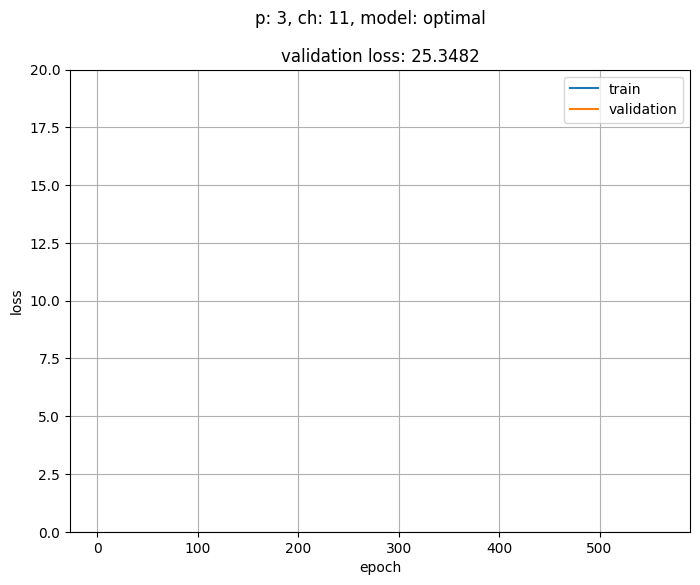

In [8]:
models = {}
for plane, channel in sorted(train_datasets[0].keys()):
    display(HTML(f'<h3>Plane: {plane}, channel: {channel}</h3>'))

    train_X_list, train_y_list, test_X_list, test_y_list = [], [], [], []
    for dataset in train_datasets:
        X, y = dataset[(plane, channel)]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE,
                                                            random_state=TRAIN_TEST_SPLIT_RANDOM_STATE)

        Y_heatmap_train = np.array([gaussian_kernel(y) for y in y_train])
        Y_heatmap_test = np.array([gaussian_kernel(y) for y in y_test])

        train_X_list.append(X_train)
        train_y_list.append(Y_heatmap_train)
        test_X_list.append(X_test)
        test_y_list.append(Y_heatmap_test)

    X_train_all = np.concatenate(train_X_list)
    y_train_all = np.concatenate(train_y_list)
    X_test_all = np.concatenate(test_X_list)
    y_test_all = np.concatenate(test_y_list)

    # Network
    model = optimal_model_builder_ch_2_11()
    try:
        history = train_model(model, f'optimal_{plane}_{channel}', X_train=X_train_all, y_train=y_train_all,
                              X_val=X_test_all, y_val=y_test_all, train=False)
    except (FileNotFoundError, NotFoundError, ValueError):
        print(f'Could not find the model for ({plane}, {channel}). Setting train=True')
        history = train_model(model, f'optimal_{plane}_{channel}', X_train=X_train_all, y_train=y_train_all,
                              X_val=X_test_all, y_val=y_test_all, train=True)

    plot_history(history, f'p: {plane}, ch: {channel}, model: optimal', ymax=20)

    models[(plane, channel)] = model

# Test

Processing p=1, ch=2...
1/1 [==============================] - 0s 172ms/step
       CFD: 77.49 ps
   optimal: 159.36 ps (improvement: -105.64 %)
Processing p=1, ch=11...


C:\Users\MatiX\miniconda3\envs\cern-ml\lib\site-packages\statsmodels\stats\weightstats.py:196: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var)


1/1 [==============================] - 0s 156ms/step
       CFD: 84.66 ps
   optimal: 101.08 ps (improvement: -19.40 %)
Processing p=2, ch=2...
1/1 [==============================] - 0s 153ms/step
       CFD: 92.08 ps
   optimal: 76.51 ps (improvement: 16.91 %)
Processing p=2, ch=11...
1/1 [==============================] - 0s 156ms/step
       CFD: 79.07 ps
   optimal: 87.38 ps (improvement: -10.51 %)
Processing p=3, ch=2...
1/1 [==============================] - 0s 150ms/step
       CFD: 78.97 ps
   optimal: 80.15 ps (improvement: -1.50 %)
Processing p=3, ch=11...
1/1 [==============================] - 0s 160ms/step
       CFD: 87.48 ps
   optimal: 91.91 ps (improvement: -5.06 %)


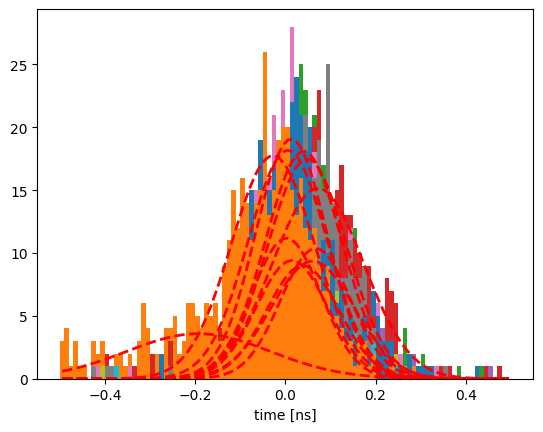

In [9]:
improvements = {}
for (plane, channel), (all_X, all_y) in test_dataset.items():
    print(f'Processing p={plane}, ch={channel}...')

    _, X_test, _, y_test = train_test_split(all_X, all_y, test_size=TEST_SIZE, random_state=TRAIN_TEST_SPLIT_RANDOM_STATE)

    cfd = CFD(n_baseline=N_BASELINE, threshold=optimal_cfd_thresholds[(plane, channel)])
    y_pred_cfd = cfd.predict(X_TIME, X_test)
    std_cfd, _, _ = plot_difference_hist(y_test, y_pred_cfd, show=False, close=False)

    model = models[(plane, channel)]
    y_pred_model = model_predict(model, X_test)
    std_model, _, _ = plot_difference_hist(y_test, y_pred_model, show=False, close=False)

    compare_results([std_model], ["optimal"], std_cfd)
    improvements[(plane, channel)] = (std_cfd, std_model, 1 - std_model / std_cfd)

In [10]:
print('Improvements:')
for (plane, channel), improv in improvements.items():
    print(
        f'({plane:>1}, {channel:>2}) CFD: {improv[0] * 1000:6.2f} ps, NN: {improv[1] * 1000:6.2f} ({improv[2] * 100:5.2f} %)')

Improvements:
(1,  2) CFD:  77.49 ps, NN: 159.36 (-105.64 %)
(1, 11) CFD:  84.66 ps, NN: 101.08 (-19.40 %)
(2,  2) CFD:  92.08 ps, NN:  76.51 (16.91 %)
(2, 11) CFD:  79.07 ps, NN:  87.38 (-10.51 %)
(3,  2) CFD:  78.97 ps, NN:  80.15 (-1.50 %)
(3, 11) CFD:  87.48 ps, NN:  91.91 (-5.06 %)
